# Classification of noisy MNIST digits

In this notebook, we will demonstrate how to use eigentasks to assist the classification of noisy MNIST digits. The notebook is divided into the following sections:
- Simulating sampling of MNIST digits illuminated by a coherent laser beam in the presence of poissonian noise to create the datasets.
- Estimating the eigentasks from the noisy dataset generated.
- Using the eigentasks to assist classification of the noisy dataset and comparing to PCA. 

In [1]:
'''Library Imports'''

#PyTorch imports for neural network training
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#sklearn imports for PCA
from sklearn.decomposition import PCA

#Standard Python Imports
import numpy as np
from tqdm import tqdm

#Plotting Imports
import matplotlib.pyplot as plt
import matplotlib
import cmasher as cmr #This is just for fancy colormaps, you don't really need it

#Imports for sampling 
import utils_sampling as sampling

#Imports for training 
import utils_training as training

## Simulating sampling of MNIST digits illuminated by a coherent laser beam in the presence of poissonian noise

In the following cells, we will assume the MNIST digit is illuminated with a plane wave coherent laser and we take images using an electron-multiplying charge coupled device (EMCCD) camera in the presence of noise. 

To keep this example simple, we use the MNIST image as the mean-field of the laser light hitting the camera. To simulate frames, we draw poissonian samples from this mean field. Again, for simplicity, we don't model read-out from the EMCCD camera and we assume the noise (dark counts) are also poissonian in nature. 

In [2]:
#Load the original MNIST dataset (see the read me file)
#There should be 12000 digits in the dataset provided on github
digits = np.load('MNIST_digits.npz')['recon_28']/255 #Divide by 255 to normalize the digits
labels = np.load('MNIST_digits.npz')['labels'] #Labels of the digits

print(f'The number of digits is {labels.shape[0]}')

The number of digits is 12000


In [3]:
signal_photons = 10 #These are the average signal photons per frame
SNR = 0.05 #Signal-to-noise ratio to determine dark counts -- the SNR is defined as avg 
#signal photons per frame/avg dark counts per frame
Number_of_frames = 100 #Number of frames to be sampled per digit - passed as np.uint16

#Drawing samples using the MNIST digits
dataset = sampling.create_noisy_dataset(images = digits, phots = signal_photons, n_frames = Number_of_frames, SNR = SNR)
print(f'The shape of the dataset is {dataset.shape}')

100%|████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:51<00:00, 232.59it/s]


The shape of the dataset is (12000, 100, 28, 28)


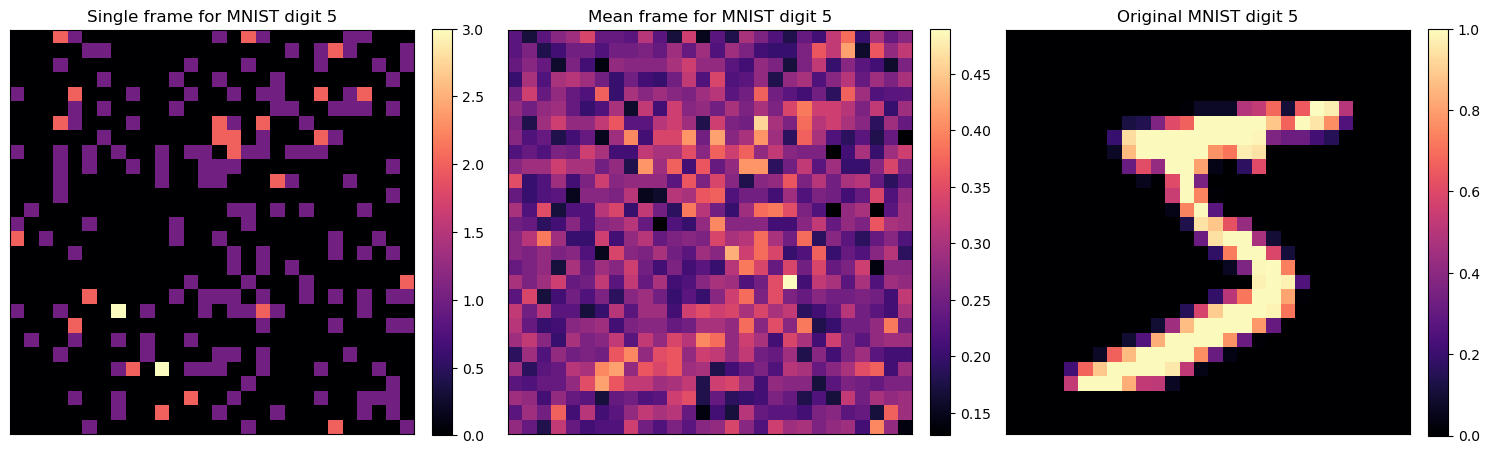

In [4]:
'''Visualizing the dataset'''
label_idx = 0
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
#
im = axes[0].imshow(dataset[label_idx][0], interpolation = 'None', \
                    origin='upper', extent=[0, 28, 0, 28], cmap = 'magma')
plt.colorbar(im, ax = axes[0], fraction = 0.046, pad = 0.04)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title(f'Single frame for MNIST digit {labels[label_idx]}')
#
im = axes[1].imshow(dataset[label_idx].mean(axis = 0), interpolation = 'None', \
                    origin='upper', extent=[0, 28, 0, 28], cmap = 'magma')
plt.colorbar(im, ax = axes[1], fraction = 0.046, pad = 0.04)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title(f'Mean frame for MNIST digit {labels[label_idx]}')
#
im = axes[2].imshow(digits[label_idx], interpolation = 'None', \
                    origin='upper', extent=[0, 28, 0, 28], cmap = 'magma')
plt.colorbar(im, ax = axes[2], fraction = 0.046, pad = 0.04)
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title(f'Original MNIST digit {labels[label_idx]}')
plt.tight_layout()
plt.show()

Once we've finished creating the samples, we will split the dataset into a train set and a test set. The number of train samples we've decided is 10000, but the user can change this. 

We compute the eigentasks on the images in the training set.

In [5]:
#Defining the size of the training and testing datasets
N_samples = labels.shape[0]
NTrain = 10000
NTest = N_samples - NTrain
rangeTest = range(N_samples)
#Setting a random seed
np.random.seed(0) 
#Creating a random permutation to split the dataset into a train set and a test set
perm = np.random.permutation(labels.shape[0]) 
#Getting train indices
train_indices = perm[np.concatenate([np.where(labels[perm] == i)[0][: int(NTrain / 10)] for i in range(10)])]
#Getting test indices
test_indices = perm[np.concatenate([np.where(labels[perm] == i)[0][int(NTrain / 10) : int(NTrain / 10) + int(NTest / 10)]for i in range(10)])]
#Combining train and test indices into one array: Test, Train
indices = np.concatenate([test_indices, train_indices])
#Taking an average across the number of frames - the shape of data_iamges will be (N_samples, 28, 28) 
data_images, labels = dataset[indices].mean(axis = 1), labels[indices]
data_train = data_images[NTest:].reshape(NTrain, -1)

print(f'The shape of the training dataset used to compute the eigentasks is {data_train.shape}')

The shape of the training dataset used to compute the eigentasks is (10000, 784)


## Estimating the eigentasks

To compute the eigentasks, we

### Covariance matrix estimation

In [6]:
#Estimating the covariance matrix V from the dataset
#Initialzing the covariance matrix to have a shape of (784, 784)
V = np.zeros((data_train.shape[-1], data_train.shape[-1]))
#XMat is the transpose of the frames for each digit - the shape should be (784, Number_of_frames)
for i in tqdm(train_indices):
    frames = dataset[i]
    XMat = frames.reshape(Number_of_frames, -1).T
    V += np.cov(XMat)
V = V / NTrain
print(f'The shape of the covariance matrix is {V.shape}')

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 295.43it/s]

The shape of the covariance matrix is (784, 784)


### Eigentasks and principal components

In [7]:
#Reshaping the entire dataset to (N_samples, 784)
#Just as a reminder the first 2000 data points are the test set
data_full = data_images.reshape(len(data_images), -1)
#Computing the eigentask weight matrix {r_k} from the training dataset and it's covariance
#rtrain
_, _, nsr, r_train = training.eigentask_solver(data_train, V=V)

#Transforming the basis from the pixel basis to the eigentask basis for the entire dataset
data_eigen = data_full @ r_train.T
#Normalzing the eigentasks - this is an arbitrary choice and can be changed or ignored
data_eigen_norm = (NTrain)*np.array(data_eigen/np.sum(data_eigen[NTest:]))
#Computing the principal components on the full dataset for comparison
#Note that we center the PCA data
_, pca = training.pca_solver(data_train)
data_pca = (data_full - np.tile(np.mean(data_train, axis = 0), (N_samples, 1)))@(pca.components_).T
data_pca_norm = (NTrain)*np.array(data_pca/np.sum(data_pca[NTest:]))
print('Pre-processing of the data finished!')
print(f'The shape of the full eigentask dataset is {data_eigen_norm.shape}')
print(f'The shape of the full PCA dataset is {data_pca_norm.shape}')

Pre-processing of the data finished!
The shape of the full eigentask dataset is (12000, 784)
The shape of the full PCA dataset is (12000, 784)


### Comparing the signal-to-noise ratio (SNR) of the eigentasks and the principal components

To look at the SNR for the eigentasks and the principal components, we apply the eigentask and principal component transformations to each frame of each digit in the test set and then plot a histogram. For the histogram we only use the first 30 eigentasks but all the principal components.

The histogram's X axis will be the SNR, and the Y axis will be the frequency (number of eigentasks or principal components with that SNR).

In [8]:
#Defining lists for the SNR estimates for the eigentasks and principal components on the test dataset
eg_snr_test = []
pca_snr_test = []
#Computing the estimate of the SNR for the eigentasks and principal components for each digit in the test dataset
for i in tqdm(range(NTest)):
    EG_data_single_MNIST = (dataset[i].reshape(Number_of_frames, -1)) @ r_train.T
    PCA_data_single_MNIST = (dataset[i].reshape(Number_of_frames, -1) - \
                             data_train.reshape(NTrain, -1).mean(axis = 0))@(pca.components_).T
    #
    eg_snr_test.append(np.abs(np.mean(EG_data_single_MNIST, axis = 0)/np.std(EG_data_single_MNIST, axis = 0)))
    pca_snr_test.append(np.abs(np.mean(PCA_data_single_MNIST, axis = 0)/np.std(PCA_data_single_MNIST, axis = 0)))
#Making the lists into np arrays
eg_snr_test = np.array(eg_snr_test)
pca_snr_test = np.array(pca_snr_test)

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:38<00:00, 52.02it/s]


1410
1388


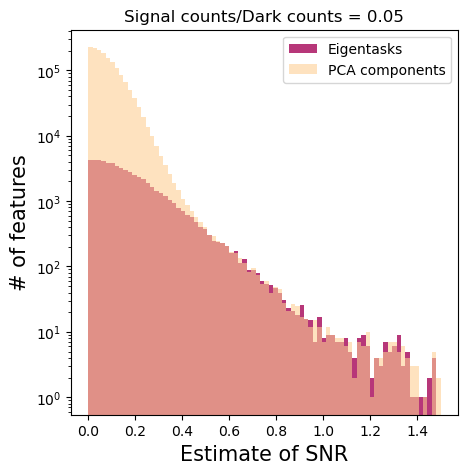

In [38]:
#Defining colors for the eigentasks and principal components
#PCA
PCA_face = [254, 207, 146, 150]
#Eigentasks
Eig_face = [183, 55, 121, 255]

number_of_comps = 30

print(np.sum(eg_snr_test[:, 1:number_of_comps + 1 + 400].flatten() > 0.6))
print(np.sum(pca_snr_test[:, :].flatten() > 0.6))

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.hist(eg_snr_test[:, 1:number_of_comps + 1].flatten(), bins = 80, range = (0., 1.5), \
        color = np.array(Eig_face)/255, label = 'Eigentasks')
ax.hist(pca_snr_test[:, :].flatten(), bins = 80, range = (0., 1.5), \
        color = np.array(PCA_face)/255, label = 'PCA components')
ax.set_yscale('log')
ax.set_title(f'Signal counts/Dark counts = {SNR}')
ax.set_xlabel(r'Estimate of SNR', fontsize = 15)
ax.set_ylabel(r'# of features', fontsize = 15)
ax.legend()
plt.show()

## Training a logistic classifier with the eigentask and principal components

In [32]:
# Initialize learning rate and number of epochs for training
init_lr, Epochs = 4e-2, 40

# Define the number of reduced features K to sweep
Lmin, Lmax = 1, 20
L_list = np.arange(Lmin, Lmax + 1)
K_list = L_list ** 2  # K values are squares of L values

# Define the types of preprocessing methods to compare
processing_list = ["eigen", "pca"]

# Initialize dictionaries to store accuracy results for each method
acc_list_logistic = {processing: [] for processing in processing_list}
acc_list_logistic_running = {processing: [] for processing in processing_list}
acc_list_linear = {processing: [] for processing in processing_list}

# Loop over each preprocessing method
for processing in processing_list:
    n_outs = len(np.unique(labels))  # Number of unique output labels

    # Loop over each K value (number of features)
    for K in tqdm(K_list):
        # Select training data based on preprocessing method
        if processing == "eigen":
            data_train = data_eigen_norm
        elif processing == "pca":
            data_train = data_pca_norm

        # Train logistic regression and store accuracy
        acc_logistic, acc_logistic_running = training.LogisticTrain(
            data_train, labels, 
            init_lr=init_lr, Epochs=Epochs, 
            K=K, rand=False, justTrain=True, 
            NTrain=NTrain, NTest=NTest, 
            rangeTest=rangeTest, runningAccuracy=True
        )
        acc_list_logistic[processing].append(acc_logistic)
        acc_list_logistic_running[processing].append(acc_logistic_running)

        # Train linear regression and store accuracy
        acc_list_linear[processing].append(
            training.LinearRegression(
                data_train, labels, 
                K=K, NTrain=NTrain, 
                NTest=NTest, rand=False, 
                rangeTest=rangeTest, bias=True
            )
        )

    # Convert accuracy lists to numpy arrays for easier processing
    acc_list_logistic[processing] = np.array(acc_list_logistic[processing])
    acc_list_logistic_running[processing] = np.array(acc_list_logistic_running[processing])
    acc_list_linear[processing] = np.array(acc_list_linear[processing])

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [03:21<00:00, 10.07s/it]


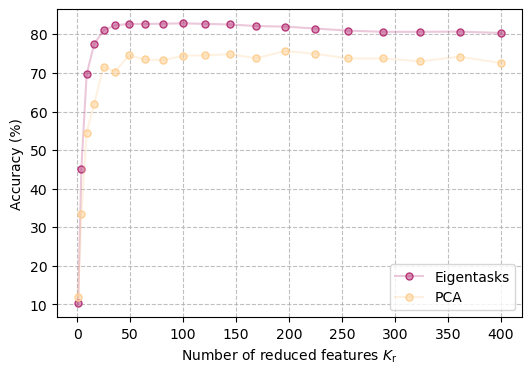

In [34]:
#Color dictionary for plotting
color_dic = {
    "pca": [254 / 255, 207 / 255, 146 / 255],
    "lpfft": [100 / 255, 26 / 255, 128 / 255],
    "eigen": [183 / 255, 55 / 255, 121 / 255],
    "cg": [247 / 255, 112 / 255, 92 / 255],
    "sy": [20 / 255, 14 / 255, 54 / 255],
}

#legen dictionary
legend_dic = {
    "pca": "PCA",
    "eigen": "Eigentasks",
}

#Transparency values
line_alpha = 70 / 255
marker_line_alpha = 255 / 255
face_alpha = 130 / 255

#Plotting the test accuracy as a function of the features sent to the classifier
scale = 1
fig, ax = plt.subplots(figsize=(6 * scale, 4 * scale))
#
processing = "eigen"
ax.plot(K_list, np.max(acc_list_logistic_running[processing], axis=2)[:, 1],marker="o",
        markersize=5 * scale,
        markerfacecolor=color_dic[processing] + [face_alpha],
        markeredgecolor=color_dic[processing] + [marker_line_alpha],
        c=color_dic[processing] + [line_alpha],
        linewidth=1.5,
        linestyle="-",
        label=legend_dic[processing],)
#
processing = "pca"
ax.plot(K_list, acc_list_logistic[processing][:, 1],marker="o",
        markersize=5 * scale,
        markerfacecolor=color_dic[processing] + [face_alpha],
        markeredgecolor=color_dic[processing] + [marker_line_alpha],
        c=color_dic[processing] + [line_alpha],
        linewidth=1.5,
        linestyle="-",
        label=legend_dic[processing],)
#
ax.set_xlabel(r"Number of reduced features $K_{\mathrm{r}}$")
ax.set_ylabel("Accuracy (%)")
ax.legend(loc="best")
ax.grid(alpha=0.8, which="major", linestyle="--")
plt.show()